In [1]:
import pandas as pd
import pickle
from db import DBHandler
import numpy as np
%matplotlib inline
# TODO: put tittles!

In [2]:
### READ FROM CSV
csv_path = '../../database/dayli_collections/dayli_col.csv'

dtypes = {
    'user.id_str': str,
    'id_str': str,
    'text': str,
    'retweeted_status.id_str': str ,
    'retweeted_status.user.id_str': str,
    'retweet_count': int,
    'in_reply_to_status_id_str': str,
}
parse_dates = ['created_at', 'retweeted_status.created_at']
df = pd.read_csv(csv_path, dtype=dtypes, parse_dates=parse_dates)
# reemplazar nombre de columnas: . por __ para sintactic sugar de pandas.
df.rename(columns=lambda x: x.replace('.', '__'), inplace=True)

In [3]:
df.tail()

,created_at,user__id_str,id_str,text,retweeted_status__id_str,retweeted_status__user__id_str,retweeted_status__created_at,retweet_count,in_reply_to_status_id_str
378490,2018-11-04 01:00:00,118732136,1058886546021994496,Horror en San Marcos Sierras\nEl Show de la Ma...,NaN,NaN,NaT,0,NaN
378491,2018-11-04 00:00:00,118732136,1058871446255079424,Preocupan los casos de violencia intrafamiliar...,NaN,NaN,NaT,0,NaN
378492,2018-11-04 23:52:00,309812848,1059231820942794752,#LaCornisa Tras más de una década de apología ...,NaN,NaN,NaT,4,NaN
378493,2018-11-04 23:31:00,309812848,1059226536136658950,"Seguimos con un país en #LaCornisa, pero sólo ...",NaN,NaN,NaT,8,NaN
378494,2018-11-04 14:52:33,84644827,1059096066493239296,RT @Guillevelez1: Entre el nuevo álbum de Juan...,1055847600337887233,909103393,2018-10-26 15:44:19,2,NaN


In [6]:
### READ FROM MONGODB CONNECTION


# h = DBHandler(port=27017)

# columns = ['created_at', 'id_str', 'retweet_count', 'retweeted_status__id_str', 'retweeted_status__created_at']
# separator = '__'
# project = ({f_name: '$' + f_name.replace(separator, '.') for f_name in columns})
# project.update({'retweeted_status': '$retweeted_status.id_str'})


# cursor = h.tweet_collection.aggregate([
#     {'$project': project}
# ])
# df = pd.DataFrame(list(cursor))

# # datatype conversion
# datetime_cols = [c for c in df.columns if 'created_at' in c]
# for c in datetime_cols:
#     df[c] = pd.to_datetime(df[c])

conecting to db


{'created_at': '$created_at',
 'id_str': '$id_str',
 'retweet_count': '$retweet_count',
 'retweeted_status__id_str': '$retweeted_status.id_str',
 'retweeted_status__created_at': '$retweeted_status.created_at',
 'retweeted_status': '$retweeted_status.id_str'}

In [19]:
# usefull aliases
def df_only_rt():
    return df[df.retweeted_status__id_str.notna()]

def df_not_rt():
    return df[df.retweeted_status__id_str.isna()]

def df_commented():
    return df[df.in_reply_to_status_id_str.notna()]

### Proporciones de RT sobre tweets totales

In [29]:
# TODO: plot this in some way
cant_rt = df_only_rt().shape[0]
cant_orig = df_not_rt().shape[0]
total = df.shape[0]
print('Cantidad de RT en el Dataset: \t{}\nCantidad de tweets originales: \t{}\nTotal: \t\t\t\t{}'.format(cant_rt, cant_orig, total))
print('Proporcion de RT sobre total: \t\t\t{}'.format(cant_rt / total))
print('Proporcion de Tweets originales sobre total: \t{}'.format(cant_orig / total))

commented_and_retweeted = df[(df.in_reply_to_status_id_str.notna()) & (df.retweeted_status__id_str.notna())].shape[0]
commented_and_not_rt = df[(df.in_reply_to_status_id_str.notna()) & (df.retweeted_status__id_str.isna())].shape[0]
print('Cantidad tweets comentados y retweeteados: \t{}'.format(commented_and_retweeted))
print('Cantidad tweets comentados y NO retweeteados: \t{}'.format(commented_and_not_rt))

Cantidad de RT en el Dataset: 	110711
Cantidad de tweets originales: 	267784
Total: 				378495
Proporcion de RT sobre total: 			0.2925032034769284
Proporcion de Tweets originales sobre total: 	0.7074967965230716
Cantidad tweets comentados y retweeteados: 	0
Cantidad tweets comentados y NO retweeteados: 	74397


### Promedio de conteos de retweets

In [31]:
avg_retweets_all = df.retweet_count.mean()
print('Promedio de retweet counts (todo el dataset): \t\t{}'.format(avg_retweets_all))
### Promedio de retweets SIN retweets
avg_retweets_nort = df_not_rt().retweet_count.mean()
print('Promedio de retweet counts (solo tweets originales): \t{}'.format(avg_retweets_nort))
avg_retweets_onlyrt = df_only_rt().retweet_count.mean()
print('Promedio de retweet counts (solo retweets): \t\t{}'.format(avg_retweets_onlyrt))
# cual es la cuenta que debería dar??

Promedio de retweet counts (todo el dataset): 		230.27960739243582
Promedio de retweet counts (solo tweets originales): 	20.10311669106444
Promedio de retweet counts (solo retweets): 		738.647352114966


### Ventanas de tiempo recogidas

In [33]:
print('Tweet más temprano en el tiempo: \t{}'.format(df.created_at.min()))
print('Tweet más tardío en el tiempo: \t\t{}'.format(df.created_at.max()))
### TODO: lo mismo pero discriminado por usuario

Tweet más temprano en el tiempo: 	2018-10-28 00:00:00
Tweet más tardío en el tiempo: 		2018-11-04 23:59:56


In [16]:
max_of_mins = df.created_at.groupby(df.user__id_str).min().max()
print('Menor fecha de tweet disponible para todos los usuarios: {}'.format(max_of_mins))

Menor fecha de tweet disponible para todos los usuarios: 2018-11-04 23:45:16


### Histograma de tweets y retweets por fecha

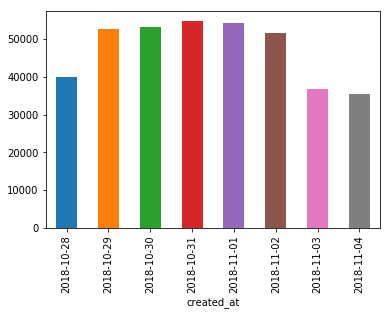

In [36]:
df.created_at.groupby(df["created_at"].dt.date).count().plot(kind="bar")

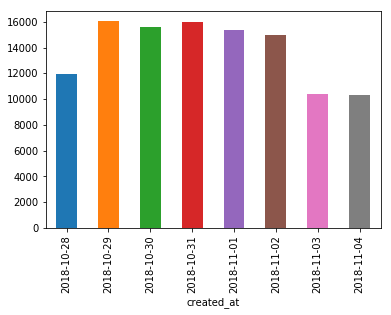

In [12]:
# retweets
df.created_at.groupby(df_only_rt()["created_at"].dt.date).count().plot(kind="bar")

### Histograma de tweets y retweets por hora

Nota: se dejan afuera las primeras n horas por exceder los ordenes de magnitud para el ploteo

In [20]:
### retweets por hora
df['time_diff'] = df_only_rt().created_at - df_only_rt().retweeted_status__created_at
counts_per_hour = df_only_rt().time_diff.groupby((df_only_rt().time_diff / np.timedelta64(1, 'D')).round(0)).count()

time_diff
0.0    89496
1.0    15610
2.0     2305
Name: time_diff, dtype: int64


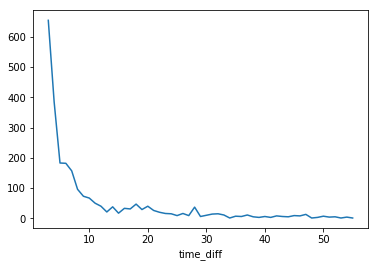

In [22]:
n_head_outliers = 3
first_n_hours_considered = 56

print(counts_per_hour.head(n_head_outliers))
counts_per_hour.head(first_n_hours_considered)[n_head_outliers:].plot(kind="line")

In [66]:
## FALTA EL PROMEDIO DE RETWEETS!!

numpy.timedelta64(3,'m')

### Retweets por hora de los primeros n tweets

In [45]:
n = 5
top_retweeted = df.nlargest(5, 'retweet_count')
top_retweeted

,created_at,user__id_str,id_str,text,retweeted_status__id_str,retweeted_status__user__id_str,retweeted_status__created_at,retweet_count,in_reply_to_status_id_str,time_diff
49764,2018-10-29 14:35:04,92430621,1056917339290054656,RT @ErickHdz56: Flip your phone upside down ht...,1056643476840955905,772540557289586689,2018-10-28 20:26:51,385289,NaN,0 days 18:08:13
185157,2018-10-31 02:18:03,149714641,1057456638439890949,RT @keepdwightgirl: Halloween is canceled http...,1056986168024330240,24520812,2018-10-29 19:08:34,323799,NaN,1 days 07:09:29
174178,2018-10-31 10:18:01,154602995,1057577426228776961,RT @keepdwightgirl: Halloween is canceled http...,1056986168024330240,24520812,2018-10-29 19:08:34,323712,NaN,1 days 15:09:27
144863,2018-10-30 02:21:08,195412602,1057095025652350977,RT @keepdwightgirl: Halloween is canceled http...,1056986168024330240,24520812,2018-10-29 19:08:34,258793,NaN,0 days 07:12:34
143782,2018-10-30 12:08:24,28633244,1057242817330855937,RT @keepdwightgirl: Halloween is canceled http...,1056986168024330240,24520812,2018-10-29 19:08:34,258741,NaN,0 days 16:59:50


Primer intento: ¿los tweets con más retweet counts aparecen en los storylines de otros users considerados?

In [47]:
for t_id in top_retweeted.id_str:
    retweeted = df[df.retweeted_status__id_str == str(t_id)]
    print(retweeted.shape[0])

0
0
0
0
0


Segundo intento: considerar los top retweet_counts que sí ...

In [35]:
for t_id in top_retweeted.id_str:
    retweeted = df[df.retweeted_status__id_str == str(t_id)]
    retweeted['time_diff'] = retweeted.created_at - retweeted.retweeted_status__created_at
    retweeted.time_diff.groupby((retweeted.time_diff / np.timedelta64(1, 'h')).round(0)).count().plot(kind="bar")

TypeError: Empty 'DataFrame': no numeric data to plot

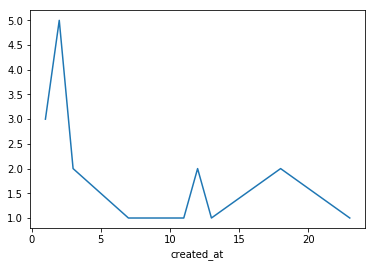

In [44]:
retweeted = df[df.retweeted_status__id_str == str(1056986168024330240)]
retweeted.created_at.groupby(retweeted["created_at"].dt.hour).count().plot(kind="line")

In [37]:
row_max_rt = df.retweet_count.idxmax()
print(df.iloc[row_max_rt, :])
print(row_max_rt)
print(type(row_max_rt))

created_at                                                      2018-10-29 14:35:04
user__id_str                                                               92430621
id_str                                                          1056917339290054656
text                              RT @ErickHdz56: Flip your phone upside down ht...
retweeted_status__id_str                                        1056643476840955905
retweeted_status__user__id_str                                   772540557289586689
retweeted_status__created_at                                    2018-10-28 20:26:51
retweet_count                                                                385289
in_reply_to_status_id_str                                                       NaN
Name: 49764, dtype: object
49764
<class 'int'>
